# Bike share pyspark walkthrough for SQL Saturday talk

## Obtain

In [1]:
data_path = "hdfs:///user//hadoop//data//bike_sharing.csv"
header_path = "hdfs:///user//hadoop//data//bike_sharing_headers.csv"

### Read into RDD

In [2]:
header_rdd = sc.textFile(header_path).filter(lambda x: x != "")

plaintext_rdd = sc.textFile(data_path).filter(lambda x: x != "")

plaintext_rdd = header_rdd.union(plaintext_rdd)

print plaintext_rdd.take(2)


[u'instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt', u'1,1/1/11,spring,0,1,0,0,6,0,clear,0.24,0.2879,0.81,0,3,13,16']


### Convert RDD to Dataframe

In [3]:
import pyspark_csv_mod as pycsv
sc.addPyFile('pyspark_csv_mod.py')

In [4]:
dataframe = pycsv.csvToDataFrame(sqlCtx, plaintext_rdd, 
                                 sep =",", parseDate=False)
dataframe.first()

Row(instant=1, dteday=u'1/1/11', season=u'spring', yr=0, mnth=1, hr=0, holiday=0, weekday=6, workingday=0, weathersit=u'clear', temp=0.24, atemp=0.2879, hum=0.81, windspeed=0.0, casual=3, registered=13, cnt=16)

In [5]:
dataframe.dtypes


[('instant', 'int'),
 ('dteday', 'string'),
 ('season', 'string'),
 ('yr', 'int'),
 ('mnth', 'int'),
 ('hr', 'int'),
 ('holiday', 'int'),
 ('weekday', 'int'),
 ('workingday', 'int'),
 ('weathersit', 'string'),
 ('temp', 'double'),
 ('atemp', 'double'),
 ('hum', 'double'),
 ('windspeed', 'double'),
 ('casual', 'int'),
 ('registered', 'int'),
 ('cnt', 'int')]

In [6]:
dataframe.describe(dataframe.columns[1:5]).show()

+-------+------+------+-------------------+-----------------+
|summary|dteday|season|                 yr|             mnth|
+-------+------+------+-------------------+-----------------+
|  count| 17379| 17379|              17379|            17379|
|   mean|  null|  null| 0.5025605615973301|6.537775476149376|
| stddev|  null|  null|0.49999344348131836|3.438676777528789|
|    min|1/1/11|  fall|                  0|                1|
|    max|9/9/12|winter|                  1|               12|
+-------+------+------+-------------------+-----------------+



In [7]:
dataframe.describe(["season", "casual", "registered", "cnt"]).show()

+-------+------+------------------+------------------+------------------+
|summary|season|            casual|        registered|               cnt|
+-------+------+------------------+------------------+------------------+
|  count| 17379|             17379|             17379|             17379|
|   mean|  null| 35.67621842453536|153.78686920996606|189.46308763450142|
| stddev|  null|49.303611843417976| 151.3529312470881| 181.3823804311691|
|    min|  fall|                 0|                 0|                 1|
|    max|winter|               367|               886|               977|
+-------+------+------------------+------------------+------------------+



In [8]:
(dataframe.filter("season = 'spring'")
          .filter("yr = 1")
          .describe(["season", "casual", "registered", "cnt"])
          .show())

+-------+------+-----------------+------------------+------------------+
|summary|season|           casual|        registered|               cnt|
+-------+------+-----------------+------------------+------------------+
|  count|  2174|             2174|              2174|              2174|
|   mean|  null|18.02989880404784|129.78426862925483|147.81416743330266|
| stddev|  null|33.17212128339912|126.00430006459575|143.66992177564128|
|    min|spring|                0|                 1|                 1|
|    max|spring|              367|               681|               801|
+-------+------+-----------------+------------------+------------------+



In [9]:
(dataframe.filter("season = 'summer'")
          .filter("yr = 1")
          .describe(["season", "casual", "registered", "cnt"])
          .show())

+-------+------+------------------+------------------+------------------+
|summary|season|            casual|        registered|               cnt|
+-------+------+------------------+------------------+------------------+
|  count|  2206|              2206|              2206|              2206|
|   mean|  null|57.097914777878515|201.86536718041705|258.96328195829557|
| stddev|  null| 68.19252002331073|175.92803664307286|215.96898809669364|
|    min|summer|                 0|                 0|                 1|
|    max|summer|               361|               782|               957|
+-------+------+------------------+------------------+------------------+



## Scrub
Change string features into integers to be consistent with modeling algorithms

In [10]:
dataframe.groupBy('season').count().show()

+------+-----+
|season|count|
+------+-----+
|  fall| 4496|
|spring| 4242|
|summer| 4409|
|winter| 4232|
+------+-----+



In [11]:
(dataframe.withColumn('temp1', dataframe.yr * 2 + 2)
          .select(["yr","temp1"])
          .show(5))

+--+-----+
|yr|temp1|
+--+-----+
| 0|    2|
| 0|    2|
| 0|    2|
| 0|    2|
| 0|    2|
+--+-----+



In [12]:
from pyspark.sql import functions as F
(dataframe.withColumn('temp2', (F.when(dataframe.season == 'spring',0)
                              .when(dataframe.season == 'summer',1)
                              .when(dataframe.season == 'fall',2)
                              .when(dataframe.season == 'winter',3)
                              .otherwise(5)))
                              .groupBy('temp2')
                              .count()
                              .show(5))

+-----+-----+
|temp2|count|
+-----+-----+
|    0| 4242|
|    1| 4409|
|    2| 4496|
|    3| 4232|
+-----+-----+



## Mapping functions over a data set
Define a transformation function that applies to a single record and then map it onto each record in a distributed way.

Notice that the mapping returns an RDD.
Why?

    You can do anything in the transformation function - the schema will not be preserved.

In [13]:
print dataframe.first()

def transform_season(record):
    new_record = []
    for index, entry in enumerate(record):
        if index != 2:
            new_record.append(entry)
        else:
            if entry == 'spring':
                new_record.append(0)
            elif entry == 'summer':
                new_record.append(1)
            elif entry == 'fall':
                new_record.append(2)
            elif entry == 'winter':
                new_record.append(3)
    return new_record

transformed_rdd = dataframe.map(transform_season)

print transformed_rdd.first()

Row(instant=8783, dteday=u'1/6/12', season=u'spring', yr=1, mnth=1, hr=18, holiday=0, weekday=5, workingday=1, weathersit=u'clear', temp=0.5, atemp=0.4848, hum=0.29, windspeed=0.2537, casual=28, registered=391, cnt=419)
[1, u'1/1/11', 0, 0, 1, 0, 0, 6, 0, u'clear', 0.24, 0.2879, 0.81, 0.0, 3, 13, 16]


### Apply a schema

In [14]:
from pyspark.sql.types import *
transformed_schema = []
old_schema = dataframe.schema
for index, field in enumerate(old_schema.fields):
    if index != 2:
        transformed_schema.append(field)
    else:
        transformed_schema.append(StructField('season',IntegerType(),True))
transformed_schema = StructType(transformed_schema)
transformed_df = sqlContext.createDataFrame(transformed_rdd, 
                                 schema = transformed_schema)


In [15]:
transformed_df.first()

Row(instant=1, dteday=u'1/1/11', season=0, yr=0, mnth=1, hr=0, holiday=0, weekday=6, workingday=0, weathersit=u'clear', temp=0.24, atemp=0.2879, hum=0.81, windspeed=0.0, casual=3, registered=13, cnt=16)

In [16]:
dataframe.groupBy('season').count().show()

+------+-----+
|season|count|
+------+-----+
|  fall| 4496|
|spring| 4242|
|summer| 4409|
|winter| 4232|
+------+-----+



Do the same thing for the weather situation feature

In [17]:
transformed_df.groupBy('weathersit').count().show()

+------------+-----+
|  weathersit|count|
+------------+-----+
|      cloudy| 4544|
|heavy precip|    3|
|light precip| 1419|
|       clear|11413|
+------------+-----+



In [18]:
def transform_weather(record):
    new_record = []
    for index, entry in enumerate(record):
        if index != 9:
            new_record.append(entry)
        else:
            if entry == 'clear':
                new_record.append(0)
            elif entry == 'cloudy':
                new_record.append(1)
            elif entry == 'light precip':
                new_record.append(2)
            elif entry == 'heavy precip':
                new_record.append(3)
            else:
                new_record.append(entry)
    return new_record



transformed_rdd = transformed_df.map(transform_weather)
print transformed_df.first(), "\n"
print transformed_rdd.first()

Row(instant=1, dteday=u'1/1/11', season=0, yr=0, mnth=1, hr=0, holiday=0, weekday=6, workingday=0, weathersit=u'clear', temp=0.24, atemp=0.2879, hum=0.81, windspeed=0.0, casual=3, registered=13, cnt=16) 

[1, u'1/1/11', 0, 0, 1, 0, 0, 6, 0, 0, 0.24, 0.2879, 0.81, 0.0, 3, 13, 16]


In [19]:
from pyspark.sql.types import *
transformed_schema = []
old_schema = transformed_df.schema
for index, field in enumerate(old_schema.fields):
    if index != 9:
        transformed_schema.append(field)
    else:
        transformed_schema.append(StructField('weathersit',IntegerType(),True))
transformed_schema = StructType(transformed_schema)
transformed_df = sqlContext.createDataFrame(transformed_rdd, 
                                 schema = transformed_schema)


In [20]:
transformed_df.first()

Row(instant=1, dteday=u'1/1/11', season=0, yr=0, mnth=1, hr=0, holiday=0, weekday=6, workingday=0, weathersit=0, temp=0.24, atemp=0.2879, hum=0.81, windspeed=0.0, casual=3, registered=13, cnt=16)

## Explore

### Univariate stats

In [21]:
transformed_df['season','temp', 'windspeed'].describe().show()

+-------+------------------+-------------------+-------------------+
|summary|            season|               temp|          windspeed|
+-------+------------------+-------------------+-------------------+
|  count|             17379|              17379|              17379|
|   mean|1.5016399102364923|0.49698716842164814|  0.190097606306452|
| stddev|  1.10688629256209|0.19255058126209854|0.12233670875036765|
|    min|                 0|               0.02|                0.0|
|    max|                 3|                1.0|             0.8507|
+-------+------------------+-------------------+-------------------+



### Bivariate stats

In [22]:
transformed_df.crosstab("season", "weathersit").show()

+-----------------+----+----+---+-+
|season_weathersit|   0|   1|  2|3|
+-----------------+----+----+---+-+
|                2|3280| 947|269|0|
|                1|2859|1144|406|0|
|                3|2609|1248|375|0|
|                0|2665|1205|369|3|
+-----------------+----+----+---+-+



In [23]:
for hr in range(13,21):
    hr_corr = transformed_df.filter("hr = " + str(hr)).corr('temp', 'cnt')
    print hr, hr_corr

13 0.396276166065
14 0.378465467714
15 0.388162260163
16 0.551861291267
17 0.587931522618
18 0.601333819698
19 0.677768466383
20 0.710147294589


### Visualization

Remember - graphics get rendered locally, so all data has to come to the driver node.   
  
For small data this is no problem.  
For big data, consider either sampling or using distributed binning to lighten the load on the local machine.

In [24]:
import matplotlib
if (not sc):
    matplotlib.use("tkagg")
else:
    %matplotlib inline
import pylab as plt

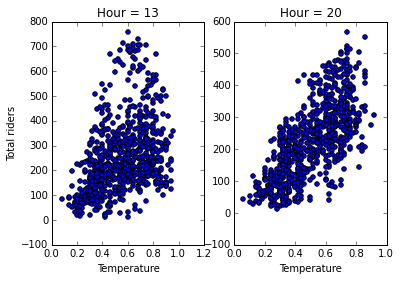

In [25]:
count = 1
for hr in [13, 20]:
    temp_data = (transformed_df
                 .filter("hr = " + str(hr))
                 .select("temp", "cnt")
                 .toPandas())
    plt.subplot(1,2,count)
    plt.scatter(x = temp_data['temp'], y = temp_data['cnt'])
    plt.title("Hour = " + str(hr))
    if count == 1:
        plt.ylabel("Total riders")
    plt.xlabel("Temperature")
    count = count + 1

## Model

### Prepare data for modeling

In [26]:
for index, x in enumerate(transformed_df.columns[0:9]):
    if index < 8:
        print "%5i %15s %20i %15s" %(index, x, index + 9, 
                                 transformed_df.columns[index + 9])
    else:
        print "%5i %15s" %(index, x)

    0         instant                    9      weathersit
    1          dteday                   10            temp
    2          season                   11           atemp
    3              yr                   12             hum
    4            mnth                   13       windspeed
    5              hr                   14          casual
    6         holiday                   15      registered
    7         weekday                   16             cnt
    8      workingday


#### Scale the data

In [27]:
fields_to_model = ["temp", "atemp", "hum", "windspeed"]
stats = transformed_df.describe(fields_to_model).collect()

for index, i in enumerate(fields_to_model):
    col_avg = float(stats[1][index + 1])
    col_stdev = float(stats[2][index + 1])
    transformed_df = transformed_df.withColumn(i + '_norm', 
                                               (transformed_df[i] - col_avg)/col_stdev)

                                 

In [28]:
(transformed_df.describe(["temp", "atemp", 
                         "temp_norm", "atemp_norm"])
               .show())

+-------+-------------------+-------------------+--------------------+--------------------+
|summary|               temp|              atemp|           temp_norm|          atemp_norm|
+-------+-------------------+-------------------+--------------------+--------------------+
|  count|              17379|              17379|               17379|               17379|
|   mean|0.49698716842164814| 0.4757751021347599|-1.77459141933407...|-1.39578575088677...|
| stddev|0.19255058126209854|0.17184527137252026|  1.0000000000002938|  0.9999999999971958|
|    min|               0.02|                0.0| -2.4772045106058256|   -2.76862492830718|
|    max|                1.0|                1.0|   2.612367245433343|  3.0505634148474168|
+-------+-------------------+-------------------+--------------------+--------------------+



#### Get data into labeled point format

In [29]:
for index, name in enumerate(transformed_df.columns):
    print "%5s           %15s" %(index, name),
    if index % 2 == 1:
        print ""

    0                   instant     1                    dteday 
    2                    season     3                        yr 
    4                      mnth     5                        hr 
    6                   holiday     7                   weekday 
    8                workingday     9                weathersit 
   10                      temp    11                     atemp 
   12                       hum    13                 windspeed 
   14                    casual    15                registered 
   16                       cnt    17                 temp_norm 
   18                atemp_norm    19                  hum_norm 
   20            windspeed_norm


In [30]:
from pyspark.mllib.regression import LabeledPoint
parsedData_rdd = transformed_df.map(lambda x: LabeledPoint(x[16], x[17:21]))

In [31]:
print transformed_df.first()
print parsedData_rdd.first()

Row(instant=8783, dteday=u'1/6/12', season=0, yr=1, mnth=1, hr=18, holiday=0, weekday=5, workingday=1, weathersit=0, temp=0.5, atemp=0.4848, hum=0.29, windspeed=0.2537, casual=28, registered=391, cnt=419, temp_norm=0.01564696173988938, atemp_norm=0.05251758045416876, hum_norm=-1.7479854458725692, windspeed_norm=0.5198962301983621)
(16.0,[-1.33464758578,-1.09328060431,0.947372499967,-1.55388851187])


### Linear regression with spark.mllib

#### Build a model

In [32]:
from pyspark.mllib.regression import LinearRegressionWithSGD, LinearRegressionModel
nrecords = float(parsedData_rdd.count())
errors = []
for num_iter in range(1,10):
    #Train Model
    model = LinearRegressionWithSGD.train(parsedData_rdd, intercept = True, 
                                          iterations = num_iter, step = 1)
    #Evaluate Model
    valuesAndPreds = parsedData_rdd.map(lambda x:(x.label, model.predict(x.features)))
    testMAE = valuesAndPreds.map(lambda (v, p): abs(v - p)).sum() / nrecords
    errors.append(testMAE)
    print valuesAndPreds.take(1)


[(16.0, -69.795497536228737)]
[(16.0, 80.151612795304885)]
[(16.0, 38.980791912671492)]
[(16.0, 45.570038003298464)]
[(16.0, 45.995501613163526)]
[(16.0, 46.240263108209746)]
[(16.0, 46.397717646423558)]
[(16.0, 46.506093131568093)]
[(16.0, 46.584454020705465)]


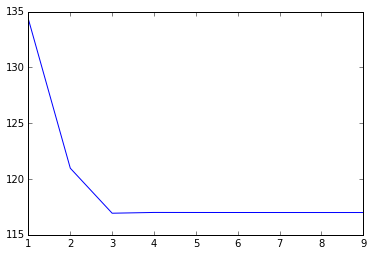

In [33]:
temp = plt.plot(range(1, 10),errors)

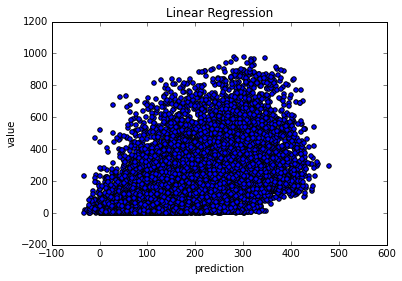

In [34]:
valuesAndPreds_local = valuesAndPreds.collect()

temp = plt.scatter([x[1] for x in valuesAndPreds_local],
                   [x[0] for x in valuesAndPreds_local])
plt.xlabel("prediction")
plt.ylabel("value")
temp = plt.title("Linear Regression")

### Random Forest with MLlib

In [35]:
from pyspark.mllib.tree import RandomForest
errors = []
for num_trees in range(1, 101, 10):
    model = RandomForest.trainRegressor(parsedData_rdd, {}, 
                                        numTrees = num_trees, maxDepth = 10, 
                                        seed=42)
    #Evaluate Model
    predictions = model.predict(parsedData_rdd.map(lambda x: x.features))
    valuesAndPreds = parsedData_rdd.map(lambda x: x.label).zip(predictions)
    testMAE = (valuesAndPreds.map(lambda (v, p): abs(v - p))
                             .sum() / nrecords)
    errors.append(testMAE)

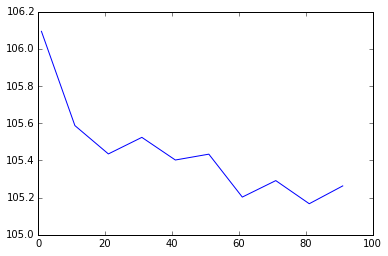

In [36]:
# Plot Errors
temp = plt.plot(range(1, 101, 10),errors)

#### Add categorical features

In [37]:
for index, name in enumerate(transformed_df.columns):
    print "%5s           %15s" %(index, name),
    if index % 2 == 1:
        print ""

    0                   instant     1                    dteday 
    2                    season     3                        yr 
    4                      mnth     5                        hr 
    6                   holiday     7                   weekday 
    8                workingday     9                weathersit 
   10                      temp    11                     atemp 
   12                       hum    13                 windspeed 
   14                    casual    15                registered 
   16                       cnt    17                 temp_norm 
   18                atemp_norm    19                  hum_norm 
   20            windspeed_norm


In [38]:
transformed_df.describe("season","yr", "hr", "mnth", ).show()

+-------+------------------+-------------------+------------------+-----------------+
|summary|            season|                 yr|                hr|             mnth|
+-------+------------------+-------------------+------------------+-----------------+
|  count|             17379|              17379|             17379|            17379|
|   mean|1.5016399102364923| 0.5025605615973301|11.546751826917545|6.537775476149376|
| stddev|  1.10688629256209|0.49999344348131836| 6.914206162513383|3.438676777528789|
|    min|                 0|                  0|                 0|                1|
|    max|                 3|                  1|                23|               12|
+-------+------------------+-------------------+------------------+-----------------+



In [39]:
transformed_df.describe("holiday", "weekday", "workingday", "weathersit").show()

+-------+--------------------+------------------+------------------+------------------+
|summary|             holiday|           weekday|        workingday|        weathersit|
+-------+--------------------+------------------+------------------+------------------+
|  count|               17379|             17379|             17379|             17379|
|   mean|0.028770355026181024| 3.003682605443351|0.6827205247712756|0.4252833879970079|
| stddev| 0.16716046691083547|2.0057137485239487|0.4654172427266846|0.6393384829652758|
|    min|                   0|                 0|                 0|                 0|
|    max|                   1|                 6|                 1|                 3|
+-------+--------------------+------------------+------------------+------------------+



In [40]:
parsedData_rdd2 = (transformed_df.withColumn("mnth2", transformed_df.mnth - 1)
                                .select("season", "yr", "mnth2", "hr",
                                       "holiday", "weekday", "workingday", "weathersit",
                                       "temp", "atemp", "hum", "windspeed", "cnt"))
print parsedData_rdd2.first()
parsedData_rdd2 = (parsedData_rdd2.map(lambda x: LabeledPoint(x[12], x[0:12])))

errors = []
for num_trees in range(10, 71, 10):
    print num_trees, 
    model = RandomForest.trainRegressor(parsedData_rdd2, {0:4, 1:2, 2:12, 3:24, 4:2, 
                                                          5:7, 6:2, 7:4}, 
                                        numTrees = num_trees, maxDepth = 10, seed=23)
    #Evaluate Model
    predictions = model.predict(parsedData_rdd2.map(lambda x: x.features))
    valuesAndPreds = (parsedData_rdd2.map(lambda x: x.label)
                      .zip(predictions))
    testMAE = valuesAndPreds.map(lambda (v, p): 
                                  abs(v - p)).sum()/ nrecords
    errors.append(testMAE) 
print ""

Row(season=0, yr=1, mnth2=0, hr=18, holiday=0, weekday=5, workingday=1, weathersit=0, temp=0.5, atemp=0.4848, hum=0.29, windspeed=0.2537, cnt=419)
10 20 30 40 50 60 70 


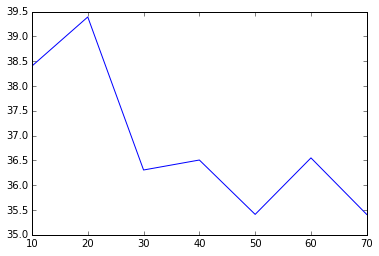

In [41]:
# Plot Errors
temp = plt.plot(range(10, 71, 10),errors)

In [42]:
#parsedData_rdd2 = (transformed_df.withColumn("mnth2", transformed_df.mnth - 1)
#                                .select("season", "yr", "mnth2", "hr",
#                                       "holiday", "weekday", "workingday", "weathersit",
#                                       "temp", "atemp", "hum", "windspeed", "cnt"))
#print parsedData_rdd2.first()
#parsedData_rdd2 = (parsedData_rdd2.map(lambda x: LabeledPoint(x[12], x[0:12])))

#errors = []
for num_trees in range(80, 101, 10):
    print num_trees, 
    model = RandomForest.trainRegressor(parsedData_rdd2, {0:4, 1:2, 2:12, 3:24, 4:2, 
                                                          5:7, 6:2, 7:4}, 
                                        numTrees = num_trees, maxDepth = 10, seed=23)
    #Evaluate Model
    predictions = model.predict(parsedData_rdd2.map(lambda x: x.features))
    valuesAndPreds = (parsedData_rdd2.map(lambda x: x.label)
                      .zip(predictions))
    testMAE = valuesAndPreds.map(lambda (v, p): 
                                  abs(v - p)).sum()/ nrecords
    errors.append(testMAE) 
print ""

80 90 100 


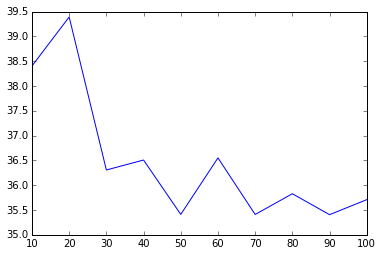

In [43]:
# Plot Errors
temp = plt.plot(range(10, 101, 10),errors)

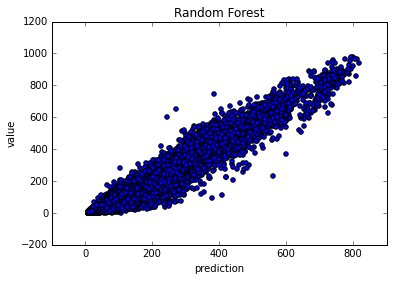

In [44]:
valuesAndPreds_local = valuesAndPreds.collect()

temp = plt.scatter([x[1] for x in valuesAndPreds_local],
                   [x[0] for x in valuesAndPreds_local])
plt.xlabel("prediction")
plt.ylabel("value")
temp = plt.title("Random Forest")

### Linear Regression with spark.ml

In [45]:
# Put data into right format

from pyspark.mllib.linalg import Vectors

temp = transformed_df.map(lambda x: (float(x[16]), Vectors.dense(x[17:21])))
parsedData_df = sqlContext.createDataFrame(temp, ["label", "features"])
parsedData_df.first()

Row(label=419.0, features=DenseVector([0.0156, 0.0525, -1.748, 0.5199]))

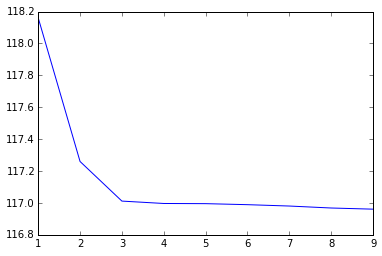

In [46]:
from pyspark.ml.regression import LinearRegression
errors = []
for num_iter in range(1,10):
    # Define model
    lr = LinearRegression(maxIter=num_iter, regParam=0.0)
    # Fit model
    lrModel = lr.fit(parsedData_df)
    # Predict model
    predictions = lrModel.transform(parsedData_df.select("features"))
    # Evaluate model
    valuesAndPreds = parsedData_df.select("label").rdd.zip(predictions.rdd)
    testMAE = valuesAndPreds.map(lambda (v, p): abs(v.label - p.prediction)
                                ).sum() / nrecords
    errors.append(testMAE)   
# Plot Errors
temp = plt.plot(range(1,10),errors)